In [19]:
import pandas as pd

# Replace 'data.xlsx' with your Excel file's name and path if it's located in a different directory
file_path = 'data.xlsx'

# Load the data from the Excel file
data = pd.read_excel(file_path)
column_to_remove = 'Unnamed: 0'
data.drop(column_to_remove, axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%b %Y')
data.set_index('Date', inplace=True)
data = data.pct_change().dropna()*100
data = data.reset_index()
data

# Replace 'data.xlsx' with your Excel file's name and path if it's located in a different directory
file_path = 'OutProcess.xlsx'

# Load the data from the Excel file
cpi = pd.read_excel(file_path)

cpi.head()

merged_df = pd.merge(data, cpi, on='Date', how='inner')
merged_df.set_index('Date', inplace=True)
merged_df.head()
# We keep the the most correlated variables
columns_to_keep = ['lag_Food', 'lag_Clothing/Shoes', 'Household/Furnishing/Equipment','GDP','CPI','Unemployment','Wages',	'Balance of Payments',	'Consumption Spending',	
                   'Inventory Investment',	'Rate']

# Create a new DataFrame with only the desired columns
df_filtered = merged_df[columns_to_keep]
new_column_names = {
    'Balance of Payments': 'BOP',
    'Consumption Spending': 'CS',
    'Inventory Investment': 'II',
    'lag_Food' :'LFood',
    'lag_Clothing/Shoes': 'LClothShoes'	,
    'Household/Furnishing/Equipment':'HouseFurnEquip'	
}

df_filtered.rename(columns=new_column_names, inplace=True)
df_filtered.index = df_filtered.index.strftime("%Y-%m")

df_filtered=((1+df_filtered/100)**12-1)*100
df_filtered.head()

C:\Users\clint\AppData\Local\Temp\ipykernel_14864\2625915480.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns=new_column_names, inplace=True)


,LFood,LClothShoes,HouseFurnEquip,GDP,CPI,Unemployment,Wages,BOP,CS,II,Rate
Date,,,,,,,,,,,
2013-02,-5.332044,-8.757873,2.127581,3.681685,14.763859,-4.199767,0.487903,13.465117,4.617450,-56.536606,2.904197
2013-03,11.554175,15.455420,3.201156,4.254620,1.973621,47.226706,6.512715,13.315896,4.599754,-59.157881,-0.830815
2013-04,0.000000,6.690294,-2.077847,2.156549,-1.935423,-11.949708,5.965968,13.169941,4.582192,-62.004555,-3.403258
2013-05,-2.687407,-6.270762,-3.107214,3.344113,2.973763,-24.433307,-10.098208,-33.017949,4.855700,583.953091,3.276578
2013-06,0.000000,1.306460,1.058658,-4.256976,0.000000,30.833758,-8.853513,-33.939046,4.836135,424.235434,0.478039


In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ten_factor_data=df_filtered

ten_factor_model= smf.ols(
    formula='CPI ~ GDP + Unemployment + Wages + Rate + CS +HouseFurnEquip+LClothShoes+LFood+II+BOP',
    data=ten_factor_data
).fit()


print(ten_factor_model.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                      -0.231
Model:                            OLS   Adj. R-squared:                 -0.242
Method:                 Least Squares   F-statistic:                    -22.18
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               1.00
Time:                        08:10:23   Log-Likelihood:                -375.72
No. Observations:                 120   AIC:                             755.4
Df Residuals:                     118   BIC:                             761.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.875e-33   5.67e-33      0.

In [21]:


cpi = ten_factor_data['CPI'].mean()
gdp = ten_factor_data['GDP'].mean()
unem = ten_factor_data['Unemployment'].mean()
wag = ten_factor_data['Wages'].mean()
bop =ten_factor_data['BOP'].mean()
rate=ten_factor_data['Rate'].mean()
cs=ten_factor_data['CS'].mean()
ii=ten_factor_data['II'].mean()
hfe=ten_factor_data['HouseFurnEquip'].mean()
lclothsho=ten_factor_data['LClothShoes'].mean()
lfood=ten_factor_data['LFood'].mean()

intercept, b1, b2, b3,b4,b5,b6,b7,b8,b9,b10 = ten_factor_model.params

expected_cpi = intercept+b1 * gdp + b2 * unem +b3 * wag +b4*rate+b5*cs+b6*hfe+b7*lclothsho+b8*lfood+b9* ii +b10* bop

print("Expected Inflation: " + str(expected_cpi))


Expected Inflation: 0.09187571167433382


Number of rows: 120


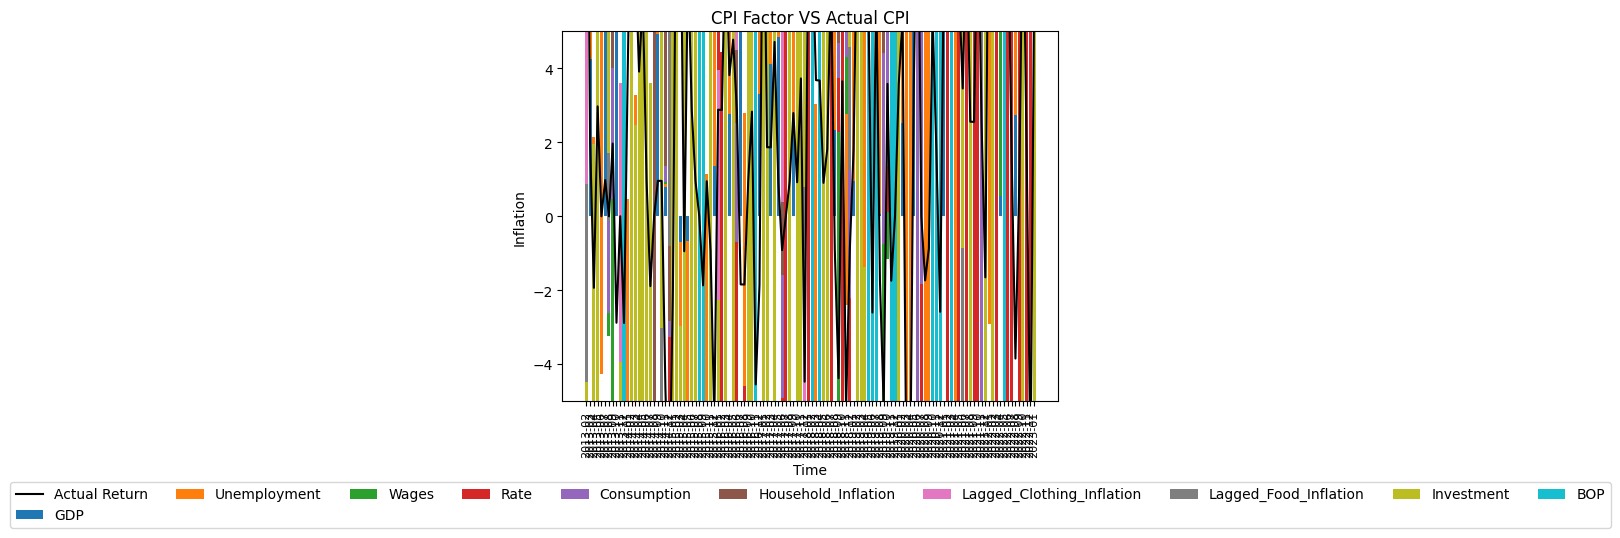

In [22]:
num_rows = len(ten_factor_data)
import numpy as np
import matplotlib.pyplot as plt

print("Number of rows:", num_rows)
time=num_rows

categories = ['GDP', 'Unemployment', 'Wages', 'Rate','Consumption','Household_Inflation','Lagged_Clothing_Inflation','Lagged_Food_Inflation','Investment','BOP']
time_periods = ten_factor_data.index[:time].tolist()
data = np.array([ten_factor_data['GDP'].tolist()[:time],  # mkt
                 ten_factor_data['Unemployment'].tolist()[:time],   # smb'CPI ~ GDP + Unemployment + Wages + BOP + Rate + CS + II+HouseFurnEquip+LClothShoes+LFood'
                 ten_factor_data['Wages'].tolist()[:time],
                 ten_factor_data['Rate'].tolist()[:time],
                 ten_factor_data['CS'].tolist()[:time],   # cma
                 ten_factor_data['HouseFurnEquip'].tolist()[:time],
                 ten_factor_data['LClothShoes'].tolist()[:time],
                 ten_factor_data['LFood'].tolist()[:time],
                 ten_factor_data['II'].tolist()[:time],
                 ten_factor_data['BOP'].tolist()[:time],
                 ])  

# Create stacked bar chart
fig, ax = plt.subplots()

# Plotting each category's bar
bottom = np.zeros(len(time_periods))
for i, category in enumerate(categories):
    ax.bar(time_periods, data[i], bottom=bottom, label=category)
    bottom += data[i]

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Inflation')
ax.set_title('CPI Factor VS Actual CPI')
ax.legend()

# Calculate trend line
x = np.arange(len(time_periods))
y=ten_factor_data['CPI'].tolist()[:time]

# Plot the trend line
ax.plot(x, y, color='black', label='Actual Return')
ax.legend()

# Set the legend below the graph
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(categories))

# Set the x-axis tick labels to display horizontally
plt.xticks(rotation=90)
plt.xticks(fontsize=8)

plt.ylim(-5, 5)
# Display the chart
plt.show()
